In [1]:
from datasets import load_dataset

mnist = load_dataset("mnist")

README.md: 0.00B [00:00, ?B/s]

c:\Users\L03055876\Desktop\AI_impacto_empresarial\ai_ml_env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\L03055876\.cache\huggingface\hub\datasets--mnist. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to r

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
mnist["train"]["image"][1]

In [5]:
mnist["train"]["label"][1]

0

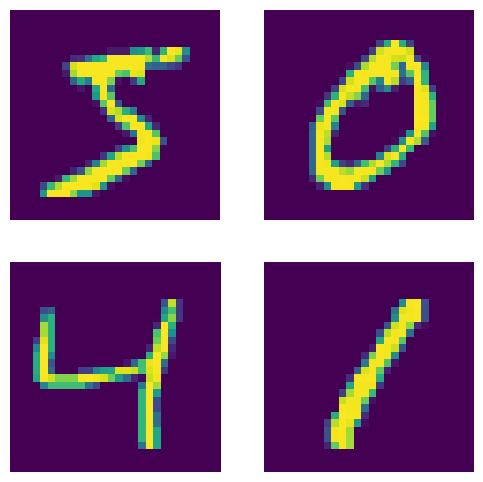

In [8]:
from genaibook.core import show_images

show_images(mnist["train"]["image"][:4])

In [10]:
from torchvision import transforms

def mnist_to_tensor(samples):
    t = transforms.ToTensor()
    samples["image"] = [t(img) for img in samples["image"]]
    return samples

In [11]:
mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=42)

In [12]:
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

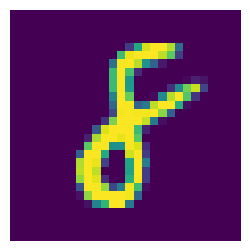

In [14]:
show_images(mnist["train"]["image"][0])

In [15]:
from torch.utils.data import DataLoader

bs = 64
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

In [17]:
from torch import nn

def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [18]:
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256)
        self.conv3 = conv_block(256, 512)
        self.conv4 = conv_block(512, 1024)
        self.linear = nn.Linear(1024, 16)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.linear(x.flatten(start_dim=1))
        return x

In [19]:
mnist["train"]["image"][0].shape

torch.Size([1, 28, 28])

In [20]:
in_channels = 1
x = mnist["train"]["image"][0][None, :]
encoder = Encoder(in_channels).eval()

encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [22]:
encoded

tensor([[ 0.0266,  0.0265,  0.0059, -0.0245, -0.0143, -0.0100, -0.0154, -0.0087,
         -0.0046, -0.0299,  0.0077, -0.0306, -0.0233, -0.0101, -0.0042, -0.0229]],
       grad_fn=<AddmmBackward0>)

In [23]:
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels=1)(batch)
batch.shape, encoded.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

In [24]:
def conv_transpose_block(
    in_channels,
    out_channels,
    kernel_size=3,
    stride=2,
    padding=1,
    output_padding=0,
    with_act=True,
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
        nn.BatchNorm2d(out_channels),
    ]
    if with_act:
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
    return nn.Sequential(*modules)

In [26]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.linear = nn.Linear(16, 1024*4*4)
        self.t_conv1 = conv_transpose_block(1024, 512)
        self.t_conv2 = conv_transpose_block(512, 256, output_padding=1)
        self.t_conv3 = conv_transpose_block(256, out_channels, output_padding=1)
        
    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 4, 4))
        x = self.t_conv1(x)
        x = self.t_conv2(x)
        x = self.t_conv3(x)
        return x

In [28]:
decoded_batch = Decoder(x.shape[0])(encoded)
decoded_batch.shape

torch.Size([64, 1, 28, 28])

In [31]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = Decoder(in_channels)
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [32]:
model = AutoEncoder(1)

In [33]:
import torchsummary

torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [34]:
from genaibook.core import get_device

get_device()

device(type='cpu')

In [ ]:
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange

from genaibook.core import get_device

num_epochs = 10
lr = 1e-4

device = get_device() #"mps"
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

losses = []
for _ in (progress := trange(num_epochs, desc = "Training")):
    for _, batch in (
        inner := tqdm(enumerate(train_dataloader), 
                      total=len(train_dataloader))
    ):
        batch = batch.to(device)
        preds = model(batch)
        loss = F.mse_loss(preds, batch)
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    progress.set_postfix(epoch_loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")



Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]